# Grid setup LUT

## Imports

In [7]:
%load_ext autoreload
%autoreload 2

# Standard imports
from collections import defaultdict
import csv
import pickle 

# 3rd party imports
import numpy as np
np.set_printoptions(linewidth=1000)
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm

# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [8]:
def _create_correspondence(y: int, x: int, angle: int, magnitude: float, n: int):
    """
    Create a correspondence for the given parameters.
    
    Parameters:
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector (degrees).
    magnitude (float): The magnitude of the vector.
    
    Returns:
    np.ndarray: The moving point.
    np.ndarray: The fixed point.
    """
    angle = np.radians(angle)
    mpoint = np.array([0, y, x])
    fpoint_y = y + np.sin(angle) * magnitude
    fpoint_x = x + np.cos(angle) * magnitude
    fpoint = np.array([0, fpoint_y, fpoint_x])
    # Check bounds
    if fpoint_y < 0 or fpoint_x < 0 or fpoint_y > n - 1 or fpoint_x > n - 1:
        raise Exception(f"Invalid correspondence, out of bounds: {mpoint} -> {fpoint}")
    return mpoint, fpoint


def create_case(y: int, x: int, angle: int, magnitude: float, base_mpoints: np.ndarray, base_fpoints: np.ndarray, n: int=7, pad=True):
    """
    Create a case for the given parameters.
    
    Parameters:
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector (degrees).
    magnitude (float): The magnitude of the vector.
    base_mpoints (np.ndarray): The base moving points.
    base_fpoints (np.ndarray): The base fixed points.
    n (int): The size of the grid.
    
    Returns:
    np.ndarray: The deformation field.
    np.ndarray: The Jacobian determinant field.
    """
    #new_size = 15  # 15 x 15
    #pad_size = (new_size - n) // 2
    #fixed_resolution = np.zeros((1, new_size, new_size))
    fixed_resolution = np.zeros((1, n, n))
    # Create the correspondence and apply as the second correspondence in the grid
    mpoint, fpoint = _create_correspondence(y, x, angle, magnitude, n)
    #mpoint += np.array([0, pad_size, pad_size])
    #fpoint += np.array([0, pad_size, pad_size])
    curr_mpoints = base_mpoints.copy()
    curr_fpoints = base_fpoints.copy()
    curr_mpoints = np.append(curr_mpoints, [mpoint], axis=0)
    curr_fpoints = np.append(curr_fpoints, [fpoint], axis=0)
    # Run Laplacian and Jacobian determinant calculations and save the Jacobian determinant field
    deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
    #deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_fpoints, curr_mpoints)
    # Crop deformation field to original size
    #deformation = deformation[:, :, pad_size:pad_size + n, pad_size:pad_size + n]
    jdet_field = jacobian.sitk_jacobian_determinant(deformation)[0]
    return deformation, jdet_field


def show_data(data: dict, y: int, x: int, angle: int, magnitude: float, title="", fontsize=8):
    """
    Show the grid of deformation information.
    
    Parameters:
    data (dict): The data dictionary.
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector.
    magnitude (float): The magnitude of the vector.
    deformation (np.ndarray): The deformation field.
    title (str): The title of the plot.
    fontsize (int): The fontsize of the text.
    """
    deformation, jdet_field = data[y][x][angle][magnitude]
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())
    
    # Plot the grid of deformation information
    f = plt.figure(figsize=(10, 5))
    
    # Plot the grid of Jacobian determinants color values
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    angle_rad = np.radians(angle)
    plt.arrow(jdet_field.shape[1] // 2, jdet_field.shape[0] // 2, np.cos(0) * 1, np.sin(0) * 1, head_width=0.15, head_length=0.15, fc='green', ec='green')
    plt.arrow(x, y, np.cos(angle_rad) * magnitude, np.sin(angle_rad) * magnitude, head_width=0.15, head_length=0.15, fc='green', ec='green')
    
    # Draw a dot at moving points
    #for i in range(len(mpoints)):
    #    plt.scatter(mpoints[i][2], mpoints[i][1], color='green')
    
    # Plot the coordinate text
    for j in range(jdet_field.shape[0]):
        for i in range(jdet_field.shape[1]):
            # Get the pixel information
            normalized_y = j - (jdet_field.shape[0] // 2) 
            normalized_x = i - (jdet_field.shape[1] // 2)
            
            curr_displacement = deformation[:, 0, j, i]
            displacement_y = curr_displacement[1]
            displacement_x = curr_displacement[2]

            # Get the angle information
            curr_theta_rad = np.arctan2(displacement_y, displacement_x)
            if curr_theta_rad < 0:  # Ensure the angle is in the range [0, 2pi)
                curr_theta_rad += 2 * np.pi
            curr_theta = np.abs(np.degrees(curr_theta_rad))
            
            # Get the magnitude information
            curr_magnitude = np.linalg.norm(curr_displacement)
            jdet = jdet_field[j, i]
            
            # Setup text to display
            coord_text = f"({displacement_y:.1f}, {displacement_x:.1f})\n"
            jdet_text = f"{jdet:.2f} J"
            vector_text = f"\n{curr_theta:.2f}°\n" + f"∥{curr_magnitude:.2f}∥"
            #pixel_text = coord_text + jdet_text + vector_text
            pixel_text = jdet_text
            plt.text(i, j, pixel_text, color='black', ha='center', va='center', fontsize=fontsize, weight='normal')
            
            # Draw the vector direction
            magnitude_scale = 0.33  # To scale the vector magnitude for visualization purposes
            #plt.arrow(i, j, np.cos(curr_theta_rad) * magnitude_scale, np.sin(curr_theta_rad) * magnitude_scale, head_width=0.15, head_length=0.15, fc='black', ec='black')            

            

    # Set the xticks and yticks
    plt.xticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[1] // 2) - 1, jdet_field.shape[1] // 2) + 1)
    plt.yticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[0] // 2) - 1, jdet_field.shape[0] // 2) + 1)
    plt.title(title)
    plt.show()
    f.clear()
    plt.close(f)

### Flip case 2

In [9]:
def _create_correspondence2(y: int, x: int, angle: int, magnitude: float, n: int):
    """
    Create a correspondence for the given parameters.
    
    Parameters:
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector (degrees).
    magnitude (float): The magnitude of the vector.
    
    Returns:
    np.ndarray: The moving point.
    np.ndarray: The fixed point.
    """
    angle = np.radians(angle)
    mpoint = np.array([0, y, x])
    fpoint_y = y + np.sin(angle) * magnitude
    fpoint_x = x + np.cos(angle) * magnitude
    fpoint = np.array([0, fpoint_y, fpoint_x])
    return mpoint, fpoint

def create_case2(y: int, x: int, angle: int, magnitude: float, base_mpoints: np.ndarray, base_fpoints: np.ndarray, n: int=7, pad=True):
    """
    Create a case for the given parameters.
    
    Parameters:
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector (degrees).
    magnitude (float): The magnitude of the vector.
    base_mpoints (np.ndarray): The base moving points.
    base_fpoints (np.ndarray): The base fixed points.
    n (int): The size of the grid.
    
    Returns:
    np.ndarray: The deformation field.
    np.ndarray: The Jacobian determinant field.
    """
    #new_size = 15  # 15 x 15
    #pad_size = (new_size - n) // 2
    #fixed_resolution = np.zeros((1, new_size, new_size))
    fixed_resolution = np.zeros((1, n, n))
    # Create the correspondence and apply as the second correspondence in the grid
    mpoint, fpoint = _create_correspondence2(y, x, angle, magnitude, n)
    #mpoint += np.array([0, pad_size, pad_size])
    #fpoint += np.array([0, pad_size, pad_size])
    base_fpoints = np.array([[0, n // 2, n // 2 + 1]])
    base_mpoints = np.array([[0, n // 2, n // 2]])
    #base_fpoints = np.array([[0, n // 2, n // 2]])  # x - 1 case
    #base_mpoints = np.array([[0, n // 2, n // 2 - 1]])
    curr_mpoints = base_mpoints.copy()
    curr_fpoints = base_fpoints.copy()
    curr_mpoints = np.append(curr_mpoints, [mpoint], axis=0)
    curr_fpoints = np.append(curr_fpoints, [fpoint], axis=0)
    # Run Laplacian and Jacobian determinant calculations and save the Jacobian determinant field
    #deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
    deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_fpoints, curr_mpoints)
    # Crop deformation field to original size
    #deformation = deformation[:, :, pad_size:pad_size + n, pad_size:pad_size + n]
    jdet_field = jacobian.sitk_jacobian_determinant(deformation)[0]
    return deformation, jdet_field

def show_data2(deformation, jdet_field, y: int, x: int, angle: int, magnitude: float, title="", fontsize=8):
    """
    Show the grid of deformation information.
    
    Parameters:
    data (dict): The data dictionary.
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector.
    magnitude (float): The magnitude of the vector.
    deformation (np.ndarray): The deformation field.
    title (str): The title of the plot.
    fontsize (int): The fontsize of the text.
    """
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())
    
    # Plot the grid of deformation information
    f = plt.figure(figsize=(10, 5))
    
    # Plot the grid of Jacobian determinants color values
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    angle_rad = np.radians(angle)
    plt.arrow(jdet_field.shape[1] // 2, jdet_field.shape[0] // 2, np.cos(0) * 1, np.sin(0) * 1, head_width=0.15, head_length=0.15, fc='green', ec='green')
    plt.arrow(x, y, np.cos(angle_rad) * magnitude, np.sin(angle_rad) * magnitude, head_width=0.15, head_length=0.15, fc='green', ec='green')
    
    # Draw a dot at moving points
    #for i in range(len(mpoints)):
    #    plt.scatter(mpoints[i][2], mpoints[i][1], color='green')
    
    # Plot the coordinate text
    for j in range(jdet_field.shape[0]):
        for i in range(jdet_field.shape[1]):
            # Get the pixel information
            normalized_y = j - (jdet_field.shape[0] // 2) 
            normalized_x = i - (jdet_field.shape[1] // 2)
            
            curr_displacement = deformation[:, 0, j, i]
            displacement_y = curr_displacement[1]
            displacement_x = curr_displacement[2]

            # Get the angle information
            curr_theta_rad = np.arctan2(displacement_y, displacement_x)
            if curr_theta_rad < 0:  # Ensure the angle is in the range [0, 2pi)
                curr_theta_rad += 2 * np.pi
            curr_theta = np.abs(np.degrees(curr_theta_rad))
            
            # Get the magnitude information
            curr_magnitude = np.linalg.norm(curr_displacement)
            jdet = jdet_field[j, i]
            
            # Setup text to display
            coord_text = f"({displacement_y:.1f}, {displacement_x:.1f})\n"
            jdet_text = f"{jdet:.2f} J"
            vector_text = f"\n{curr_theta:.2f}°\n" + f"∥{curr_magnitude:.2f}∥"
            pixel_text = coord_text + jdet_text + vector_text
            #pixel_text = jdet_text
            plt.text(i, j, pixel_text, color='black', ha='center', va='center', fontsize=fontsize, weight='normal')
            
            # Draw the vector direction
            magnitude_scale = 0.33  # To scale the vector magnitude for visualization purposes
            plt.arrow(i, j, np.cos(curr_theta_rad) * magnitude_scale, np.sin(curr_theta_rad) * magnitude_scale, head_width=0.15, head_length=0.15, fc='black', ec='black')            

            

    # Set the xticks and yticks
    plt.xticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[1] // 2) - 1, jdet_field.shape[1] // 2) + 1)
    plt.yticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[0] // 2) - 1, jdet_field.shape[0] // 2) + 1)
    plt.title(title)
    plt.show()
    f.clear()
    plt.close(f)

In [10]:
def nested_dict():
    return defaultdict(nested_dict)


## Generate LUT data

In [ ]:
# User parameters
n = 7
SAVE_TO_FILE = True
pickle_filepath = 'lut_data_case2_x-1.pkl'

# Setup initial correspondence in the center pixel.
mpoints = np.array([[0, (n // 2), (n // 2)]])
fpoints = np.array([[0, (n // 2), (n // 2) + 1]])
fixed_resolution = np.zeros((1, n, n))

# Define a function to create a nested defaultdict
def nested_dict():
    return defaultdict(nested_dict)
data = nested_dict()

# Create a range of correspondences for each pixel
for y in tqdm(range(n), desc="Outer loop y"):
    for x in tqdm(range(n), desc="Outer loop x", leave=False):
        # Skip the center pixel
        if y == (n // 2) and x == (n // 2):
            continue
        # Create correspondences for each angle (degrees) [0, 360) in increments of 10]
        for angle in tqdm(range(0, 360, 10), desc="Inner loop angle", leave=False):
            
            # Create correspondences for each magnitude from [0.5, 5.0] in increments of 0.5
            for magnitude in tqdm(range(1, 11), desc="Innermost loop magnitude", leave=False):
                magnitude /= 2
                
                # Create the correspondence and apply as the second correspondence in the grid
                try:
                    deformation, jdet_field = create_case2(y, x, angle, magnitude, mpoints, fpoints)
                except Exception as e:
                    #print(f"Error: {e}")
                    #print(f"y: {y}, x: {x}, angle: {angle}, magnitude: {magnitude}")
                    continue
                data[y][x][angle][magnitude] = deformation, jdet_field
                
"""
# Create a range of correspondences for each pixel
for y in range(n):
    for x in range(n):
        # Skip the center pixel
        if y == (n // 2) and x == (n // 2):
            continue
        # Create correspondences for each angle (degrees) [0, 360) in increments of 10]
        for angle in range(0, 360, 10):
            
            # Create correspondences for each magnitude from [0.5, 5.0] in increments of 0.5
            for magnitude in range(1, 11):
                magnitude /= 2
                
                # Create the correspondence and apply as the second correspondence in the grid
                try:
                    deformation, jdet_field = create_case(y, x, angle, magnitude, mpoints, fpoints)
                except Exception as e:
                    #print(f"Error: {e}")
                    #print(f"y: {y}, x: {x}, angle: {angle}, magnitude: {magnitude}")
                    continue
                data[y][x][angle][magnitude] = deformation, jdet_field
"""

# Pickle the nested dictionary to a file
if SAVE_TO_FILE:
    with open(pickle_filepath, 'wb') as file:
        pickle.dump(data, file)

## Save to CSV spreadsheet

In [ ]:
csv_filepath = "lut_data_7x7_case2_x-1.csv"

headers = ["x", "y", "theta", "mag", "J"]
with open(csv_filepath, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    for x in tqdm(range(n), desc="Outer loop x"):
        
        for y in tqdm(range(n), desc="Outer loop y", leave=False):
            if y == (n // 2) and x == (n // 2):
                continue

            for angle in tqdm(range(0, 360, 10), desc="Inner loop angle", leave=False):
                for magnitude in tqdm(range(1, 11), desc="Innermost loop magnitude", leave=False):
                    magnitude /= 2
                    
                    try:
                        deformation_field, jdet_field = data[y][x][angle][magnitude]
                        jdet = jdet_field[n//2, n//2]
                        normalized_y = y - (jdet_field.shape[0] // 2)
                        normalized_x = x - (jdet_field.shape[1] // 2)
                        writer.writerow([normalized_x, normalized_y, angle, magnitude, jdet])
                    except Exception as e:
                        continue

## Load data and visualize it

In [26]:
# Load the pickled dictionary from the file
with open('lut_data_case2_x-1.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[-0.36169692, -0.39529177, -0.46584546, -0.55538637, -0.51691608, -0.47839175, -0.45892346],
        [-0.32793465, -0.35861308, -0.44670887, -0.68401745, -0.51744995, -0.45973369, -0.43912831],
        [-0.26420062, -0.26455551, -0.27826305, -0.40149762, -0.40946134, -0.40330518, -0

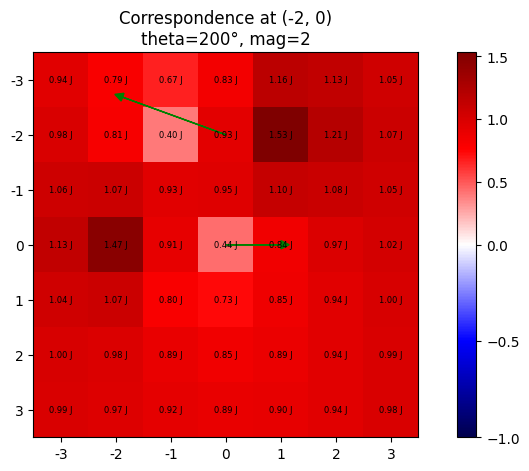

In [46]:
# Show grid information at a specific index
y, x = (-2, 0)
angle = 200
magnitude = 2
n = 7

y = y + n // 2
x = x + n // 2
# Get info
deformation, jdet_field = loaded_data[y][x][angle][magnitude]
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
show_data(loaded_data, y, x, angle, magnitude, 
          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 1.64640704,  1.70104149,  1.75287369,  1.6519755 ,  1.53402489,  1.45072253,  1.41030904],
        [ 1.59155832,  1.70507337,  1.90632299,  1.66652745,  1.4977031 ,  1.40699256,  1.36842799],
        [ 1.42258212,  1.62194654,  2.49982198,  1.60729639,  1.37820654,  1.3077246 ,  1

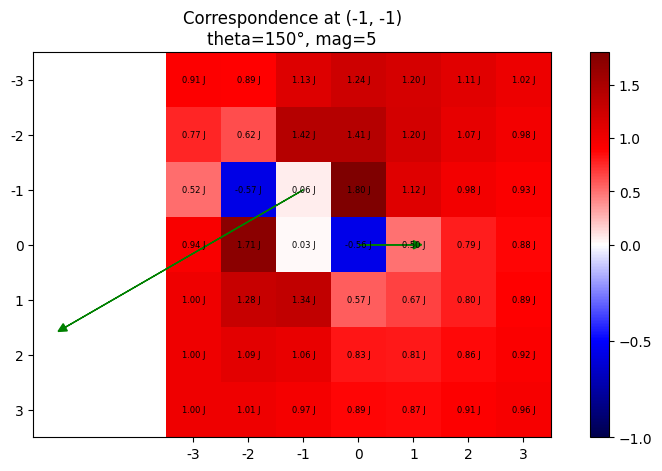

In [50]:
# Show grid information at a specific index
y, x = (-1, -1)
angle = 150
magnitude = 5
n = 7

y = y + n // 2
x = x + n // 2
# Get info
deformation, jdet_field = loaded_data[y][x][angle][magnitude]
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
show_data(loaded_data, y, x, angle, magnitude, 
          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)

### Symmetry

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0

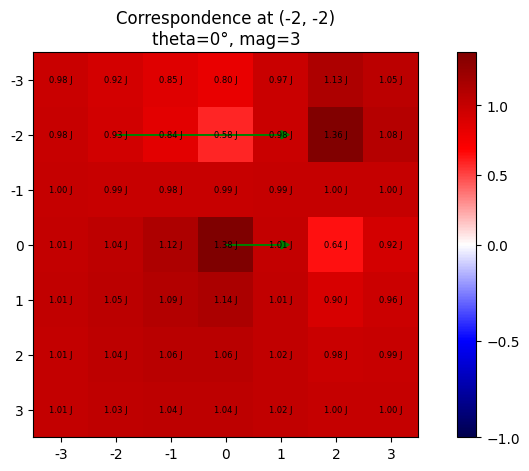

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0

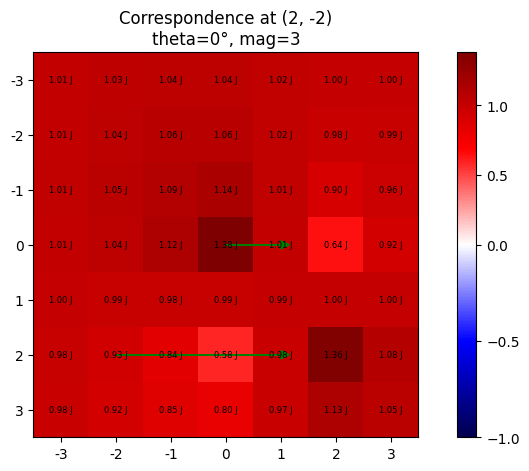

In [116]:
# Show grid information at a specific index
y, x = (1, 1)
angle = 0
magnitude = 3

# Get info
deformation, jdet_field = loaded_data[y][x][angle][magnitude]
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
show_data(loaded_data, y, x, angle, magnitude, 
          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)



# Show grid information at a specific index
y, x = (5, 1)
angle = 0
magnitude = 3

# Get info
deformation, jdet_field = loaded_data[y][x][angle][magnitude]
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
show_data(loaded_data, y, x, angle, magnitude, 
          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)

### Flip mpoints and fpoints in Laplacian and test

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0

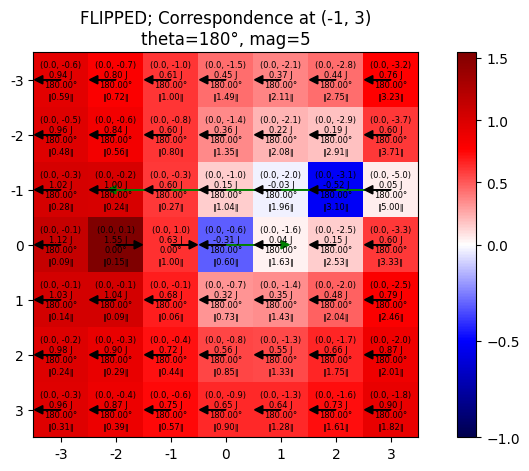

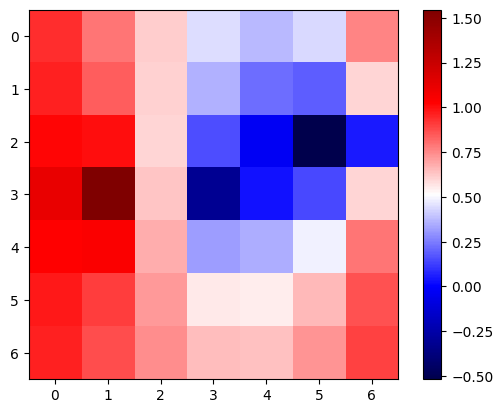

In [130]:
# Show grid information at a specific index
y, x = (2, 6)
angle = 180
magnitude = 5

# Get info
deformation, jdet_field = create_case2(y, x, angle, magnitude, mpoints, fpoints)
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
pprint(jdet_field)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
#show_data(loaded_data, y, x, angle, magnitude, 
#          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
           title=f"FLIPPED; Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)
plt.imshow(jdet_field, cmap="seismic")
plt.colorbar()
plt.show()

## Save to CSV spreadsheet

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

## Test cases

In [ ]:
# Show grid information at a specific index with padding
y, x = (1, 6)
angle = 180
magnitude = 4
deformation, jdet_field = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

pprint(deformation[2, 0, :, :])

array([[0.64020303, 1.46156278, 2.28406475, 2.21558911, 2.08099534,
        1.98604831, 1.92692108],
       [1.44410954, 2.2770204 , 4.00121193, 2.75987334, 2.30626887,
        2.10406243, 1.99972757],
       [1.71587245, 2.20129659, 2.75297276, 2.51769034, 2.2833876 ,
        2.12700457, 2.02995256],
       [1.78962598, 2.06099927, 2.29383553, 2.27767959, 2.1857604 ,
        2.09548916, 2.02675179],
       [1.80259244, 1.96237796, 2.08792489, 2.11739362, 2.09117605,
        2.04775917, 2.00700655],
       [1.80076544, 1.90189047, 1.9813757 , 2.01721577, 2.018739  ,
        2.00309906, 1.98274785],
       [1.79868756, 1.86664702, 1.92252019, 1.95531018, 1.9680542 ,
        1.96735393, 1.96131347]])


In [29]:
# Show grid information at a specific index without padding
y, x = (1, 6)
angle = 180
magnitude = 4
deformation, jdet_field = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

pprint(deformation[2, 0, :, :])

array([[ 2.87344504,  3.00647438,  3.12426878,  2.36431385,  1.66803569,
         1.24934829,  1.06321759],
       [ 2.73964279,  3.02443582,  3.99963275,  2.30554468,  1.39651857,
         1.01288883,  0.87194528],
       [ 2.31793762,  2.35399112,  2.31630485,  1.46310201,  0.59831481,
         0.52791234,  0.53966151],
       [ 1.86018703,  1.76271986,  1.44902848,  0.62441126, -0.99990819,
        -0.04130965,  0.21995232],
       [ 1.51137898,  1.38758593,  1.09424709,  0.58620487, -0.00544311,
         0.08520992,  0.17180061],
       [ 1.29231113,  1.18395841,  0.95535136,  0.62762912,  0.31775055,
         0.22940902,  0.21796178],
       [ 1.19264995,  1.09538078,  0.90522269,  0.65250406,  0.42417529,
         0.30065522,  0.25758255]])
